# Import libraries

In [1]:
import numpy as np, pandas as pd, msprime, tskit, pathlib
from pathlib import Path
from ascertainment_diploid_multi import ascertain_chip_diploid, AscertainmentConfig

In [2]:
# ------- CONFIG -------
rng = np.random.default_rng(42)
contig_length = 50_000_000             # 50 Mb window
mu = 1.25e-8                           # per-base per-gen mutation rate
N_anc = 12_000                         # ancestral Ne
split_time = 2_000                     # generations ago
m12 = m21 = 5e-4                       # symmetric migration
n_A = 500                              # samples in pop A
n_B = 500                              # samples in pop B
recomb_rate = 1e-8                     # fallback if not using a map
# Optional: use an external recombination map if you have a file:
recomb_map = None      

In [3]:
# ------- DEMOGRAPHY -------
dem = msprime.Demography()
dem.add_population(name="ancestral", initial_size=N_anc)
dem.add_population(name="A", initial_size=N_anc)
dem.add_population(name="B", initial_size=N_anc)
dem.add_population_split(time=split_time, derived=["A","B"], ancestral="ancestral")
dem.set_migration_rate("A", "B", m12)
dem.set_migration_rate("B", "A", m21)

In [4]:
# ------- ANCESTRY -------
if recomb_map is None:
    ts_anc = msprime.sim_ancestry(
        samples={"A": n_A, "B": n_B},
        sequence_length=contig_length,
        recombination_rate=recomb_rate,
        demography=dem,
        random_seed=12345,
    )
else:
    ts_anc = msprime.sim_ancestry(
        samples={"A": n_A, "B": n_B},
        recombination_rate=recomb_map,
        demography=dem,
        random_seed=12345,
    )


In [5]:
# ------- MUTATIONS -------
ts = msprime.sim_mutations(ts_anc, rate=mu, discrete_genome=True, random_seed=54321)

# ------- OUTPUT: variant table + genotypes -------
# Per-site metadata
sites = []
for v in ts.variants():
    sites.append({"pos": int(v.site.position), "id": f"sim_{v.site.id}", "alleles": v.alleles})
sites = pd.DataFrame(sites).sort_values("pos").reset_index(drop=True)

In [6]:
# Sample table: map samples to populations
sample_pops = []
for i, n in enumerate(ts.samples()):
    pop_id = ts.node(n).population
    pop_name = ts.population(pop_id).metadata.get("name") if ts.population(pop_id).metadata else None
    sample_pops.append({"sample_index": i, "node": n, "population_id": pop_id,
                        "population": pop_name if pop_name else ("A" if pop_id==1 else "B")})
sample_df = pd.DataFrame(sample_pops)

# Dense genotype matrix (variants x samples) as 0/1/2
G = np.vstack([v.genotypes for v in ts.variants()])   # shape: n_variants x n_samples
# ts.variants() yields haploid calls per sample for haploid samples; here samples are diploids by default in msprime>=1.3 if ploidy=2.
# To ensure diploid genotypes, pass ploidy=2 in sim_ancestry and reshape; or keep ploidy=1 and later combine pairs as needed.


In [7]:
# Save to your pipeline’s expected format (e.g., parquet)
outdir = pathlib.Path("simulation_realistic/msprime_A_B")
outdir.mkdir(parents=True, exist_ok=True)
sites.to_parquet(outdir / "sites.parquet", index=False)
sample_df.to_parquet(outdir / "samples.parquet", index=False)
pd.DataFrame(G).to_parquet(outdir / "genotypes_raw.parquet", index=False)

In [8]:
from pathlib import Path
import pandas as pd
from ascertainment_diploid_multi import AscertainmentConfig, ascertain_chip_diploid

base = Path("notebooks/ms_prime_tryout/simulation_realistic/msprime_A_B")
G = pd.read_parquet(base / "genotypes_raw.parquet")  # variants x haplotypes (0/1)
S = pd.read_parquet(base / "sites.parquet")          # must contain 'pos' (bp)
X = pd.read_parquet(base / "samples.parquet")        # per-haplotype; has 'population'

cfg = AscertainmentConfig(
    discovery_pops=["A","B"],        # put any pops here; can be >2
    maf_mode="pooled",               # or "any" / "all"
    maf_min=0.05, maf_max=0.50,
    n_snps_target=60_000,            # smaller for a quick run; set as needed
    ld_r2=0.2, ld_window_bp=50_000, ld_step_bp=5_000,
    # discovery_weights={"A":2.0, "B":1.0}  # optional, only for maf_mode="pooled"
)

out = ascertain_chip_diploid(
    G, S, X,
    config=cfg,
    discovery_sample_col="population",                     # adjust if your column is named differently
    outdir=base.parent / "msprime_A_B_arraylike_multi"     # new output folder alongside the original
)


FileNotFoundError: [Errno 2] No such file or directory: 'notebooks/ms_prime_tryout/simulation_realistic/msprime_A_B/genotypes_raw.parquet'

In [8]:

# Load your current files (haplotype-coded 0/1 matrix)
geno_hap = pd.read_parquet("simulation_realistic/msprime_A_B/genotypes_raw.parquet")  # variants x haplotypes
sites    = pd.read_parquet("simulation_realistic/msprime_A_B/sites.parquet")         # must have 'pos' (bp)
samples  = pd.read_parquet("simulation_realistic/msprime_A_B/samples.parquet")       # hap rows; include 'population'

cfg = AscertainmentConfig(
    discovery_pop="A",   # the population you want to mimic array ascertainment on
    maf_min=0.05, maf_max=0.50,
    n_snps_target=600_000,
    ld_r2=0.2, ld_window_bp=50_000, ld_step_bp=5_000,
    random_seed=1
)

res = ascertain_chip_diploid(
    genotypes_hap_df=geno_hap,
    sites_df=sites,
    samples_df=samples,
    config=cfg,
    pairing=None,  # set to list of (hap1_col, hap2_col) if you have a custom pairing
    discovery_sample_col="population",
    outdir=Path("simulation_realistic/msprime_A_B_arraylike")
)

# Outputs on disk:
# - genotypes_array_diploid.parquet   (variants x individuals, values in {0,1,2})
# - sites_array.parquet
# - samples_individuals.parquet       (one row per individual incl. 'population' if available)
# - ascertainment_index.parquet       (indices back to the original variants)
# - manifest.json


In [9]:
root = Path("simulation_realistic/msprime_A_B_arraylike")
G_df   = pd.read_parquet(root / "genotypes_array_diploid.parquet")  # variants × individuals
sites  = pd.read_parquet(root / "sites_array.parquet")
inds   = pd.read_parquet(root / "samples_individuals.parquet")


In [10]:
G_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,1,1,1,0,0,0,...,0,0,1,1,1,0,1,1,2,0
2,2,2,2,2,2,2,2,1,2,2,...,2,2,2,2,1,2,2,2,2,2
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,2,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7858,1,1,1,1,0,2,1,2,2,2,...,0,2,2,2,0,1,1,1,1,1
7859,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
7860,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7861,0,2,0,1,1,1,1,0,0,1,...,1,1,1,0,0,1,0,0,1,1


In [12]:
import pandas as pd
import numpy as np
from pathlib import Path

root = Path("simulation_realistic/msprime_A_B_arraylike")

# Must be the diploid file (variants × INDIVIDUALS)
G = pd.read_parquet(root / "genotypes_array_diploid.parquet").to_numpy(dtype=np.int8)
inds = pd.read_parquet(root / "samples_individuals.parquet")

print(G.shape, len(inds))  # <- columns must equal len(inds)

pops = inds["population"].to_numpy()
assert G.shape[1] == pops.shape[0], "Mismatch: G columns must equal number of individuals"

maf_by_pop = {}
for pop in np.unique(pops):
    mask = (pops == pop)                  # length = n_individuals
    p = (G[:, mask].mean(axis=1) / 2.0)   # alt allele freq
    maf_by_pop[pop] = np.minimum(p, 1 - p)


(7863, 1000) 1000


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# sklearn expects samples × features; here samples = individuals, features = variants
X = G.T                                  # shape → (n_individuals, n_variants)

# Standardize features (variants). On very large data, consider LD pruning beforehand.
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

pca = PCA(n_components=10, svd_solver="randomized", random_state=1)
PC = pca.fit_transform(Xz)                # (n_individuals × 10)

# Attach metadata
pc_df = pd.DataFrame(PC, columns=[f"PC{i+1}" for i in range(PC.shape[1])])
if "population" in inds.columns:
    pc_df["population"] = inds["population"].values

print(pca.explained_variance_ratio_[:5])


[0.02098656 0.00313388 0.00309205 0.00301056 0.00295466]


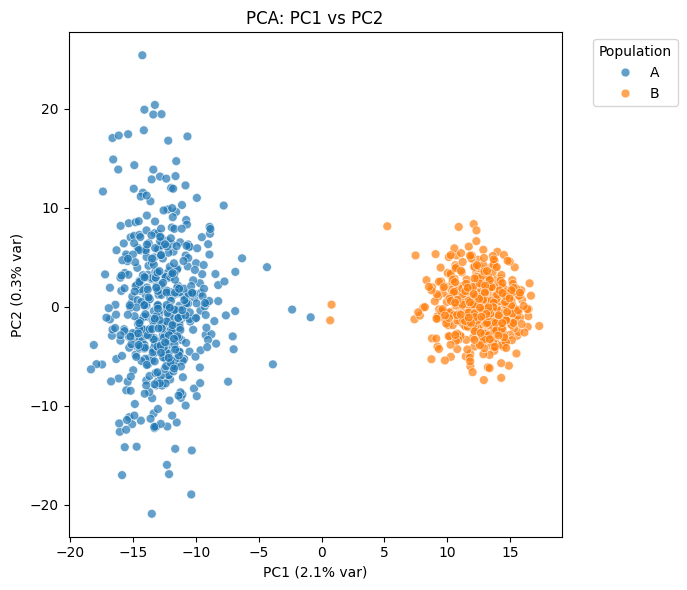

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Load data ---
root = Path("simulation_realistic/msprime_A_B_arraylike")
G = pd.read_parquet(root / "genotypes_array_diploid.parquet").to_numpy(dtype=np.int8)  # variants × individuals
inds = pd.read_parquet(root / "samples_individuals.parquet")

# --- PCA ---
X = G.T  # shape: (n_individuals, n_variants)
Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
pca = PCA(n_components=10, svd_solver="randomized", random_state=1)
PC = pca.fit_transform(Xz)

# --- Make DataFrame with metadata ---
pc_df = pd.DataFrame(PC[:, :2], columns=["PC1", "PC2"])
if "population" in inds.columns:
    pc_df["population"] = inds["population"].values

# --- Plot ---
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=pc_df,
    x="PC1", y="PC2",
    hue="population",
    palette="tab10",
    alpha=0.7, s=40
)
plt.title("PCA: PC1 vs PC2")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(title="Population", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
